### 1. Importing libraries

In [1]:
import random
import time
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.preprocessing import LabelEncoder

### 2. Loading data

In [2]:
path="https://archive.ics.uci.edu/ml/machine-learning-databases/iris/iris.data"
iris_data=pd.read_csv(path, header=None, names=['sepal_length', 'sepal_width', 'petal_length', 'petal_width', 'class'])
iris_data.head()

,sepal_length,sepal_width,petal_length,petal_width,class
0,5.1,3.5,1.4,0.2,Iris-setosa
1,4.9,3.0,1.4,0.2,Iris-setosa
2,4.7,3.2,1.3,0.2,Iris-setosa
3,4.6,3.1,1.5,0.2,Iris-setosa
4,5.0,3.6,1.4,0.2,Iris-setosa


In [3]:
iris_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 5 columns):
sepal_length    150 non-null float64
sepal_width     150 non-null float64
petal_length    150 non-null float64
petal_width     150 non-null float64
class           150 non-null object
dtypes: float64(4), object(1)
memory usage: 5.9+ KB


In [4]:
iris_data['class'].value_counts()

Iris-setosa        50
Iris-versicolor    50
Iris-virginica     50
Name: class, dtype: int64

- We ar provided with 4 features describing each class of the iris flower. 

- There are no missing values for any of the features or class.

- There 3 classes that we have classify the flower into.

## 3. Data visualisation

In [5]:
# Encoding numerical values to the three classes
label_encoder=LabelEncoder()
iris_data['species']=iris_data['class']
iris_data['class']=label_encoder.fit_transform(iris_data['class'])
iris_data.groupby(['species', 'class']).size()

species          class
Iris-setosa      0        50
Iris-versicolor  1        50
Iris-virginica   2        50
dtype: int64

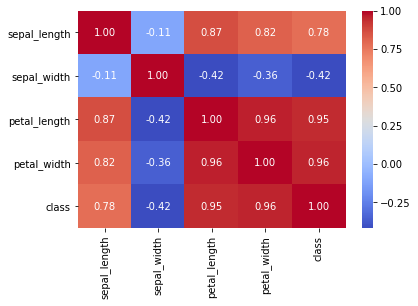

In [6]:
sns.heatmap(iris_data[['sepal_length', 'sepal_width', 'petal_length', 'petal_width', 'class']].corr(),
            annot=True, fmt=".2f", cmap="coolwarm")

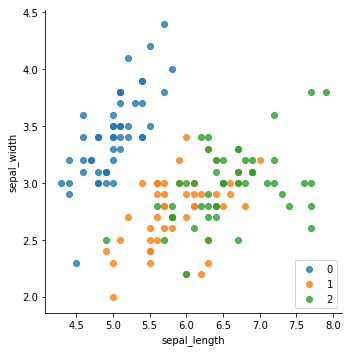

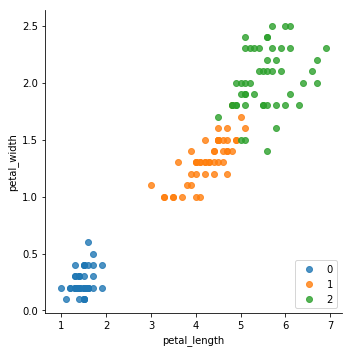

In [7]:
sns.lmplot(x='sepal_length', y='sepal_width', data=iris_data, hue='class', fit_reg=False, legend=False)
plt.legend(loc='lower right')
sns.lmplot(x='petal_length', y='petal_width', data=iris_data, hue='class', fit_reg=False, legend=False)
plt.legend(loc='lower right')

As seen from the heat map there is high correlation between class and petal_length and petal_width. There is little distinctions between the classes basis the sepal_length as well. But sepal_width has very low correlation (not that it is negative) with the class.

So, I generated two new features: petal_area and sepal_area to see if there is any clear clustering basis these two new features.

## 4. Feature engineering

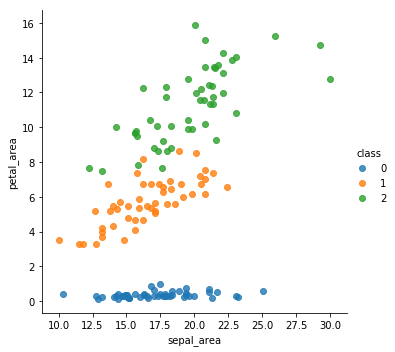

In [8]:
iris_data['sepal_area']=iris_data.apply(lambda x: (x['sepal_length'] * x['sepal_width']), axis=1)
iris_data['petal_area']=iris_data.apply(lambda x: (x['petal_length'] * x['petal_width']), axis=1)
sns.lmplot(x='sepal_area', y='petal_area', data=iris_data, hue='class', fit_reg=False)

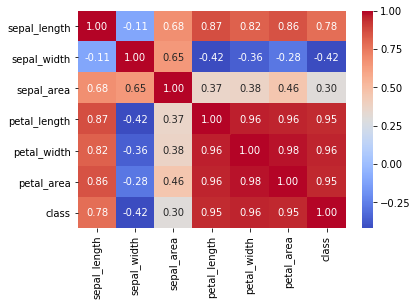

In [9]:
sns.heatmap(iris_data[['sepal_length', 'sepal_width', 'sepal_area', 'petal_length', 'petal_width', 
                       'petal_area', 'class']].corr(), annot=True, fmt='.2f', cmap='coolwarm')

sepal_area still does not help in distingushing between the three classes.

I am going to use both supervised and unspervised learning techniques for classification.

## 5. Unsupervised Learning

In [10]:
# dropping the class and species features
X=iris_data.drop(['class','species'], axis=1)
X.shape

(150, 6)

### 5.1 K-Means Clustering 

In [11]:
# Import the libraries
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

# Modeling
scaler=StandardScaler()
X_km=scaler.fit_transform(X)
KMeans_model=KMeans(n_clusters=3)
KMeans_model.fit(X_km)
label=KMeans_model.predict(X_km)
print(label)

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 2 2 2 1 2 2 2 2 2 2 2 2 1 2 2 2 2 1 2 2 2
 2 1 2 1 2 2 2 2 2 2 2 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 1 2 1 1 1 1 2 1 2 1 1
 2 1 2 2 1 1 1 1 2 1 2 1 2 1 1 2 2 1 1 1 1 1 2 2 1 1 1 2 1 1 1 2 1 1 1 2 1
 1 2]


To evaluate the accuracy of the model I used the function of crosstabulation to compare the number of species that are correctly labeled into different clusters. 

For this purpose, first a dataframe that has a column label containing the labels is obtained from Kmeans clusters and the second column that has the response column 'species' from the originial dataset. Then using pandas crosstab function with these columns we can obtain a table. According to this table we can see that the Kmeans clustering works well in detecting Iris setosa species but does not work that well for Iris versicolor for which it detected 40 in cluster 2 and 10 in cluster 1) and Iris virginica (for which it detected 33 in cluster 1 and 17 in cluster 2).

In [12]:
species=iris_data['species']
df_km=pd.DataFrame({'label':label, 'species':species})
ct=pd.crosstab(df_km['label'], df_km['species'])
print(ct)

species  Iris-setosa  Iris-versicolor  Iris-virginica
label                                                
0                 50                0               0
1                  0               10              33
2                  0               40              17


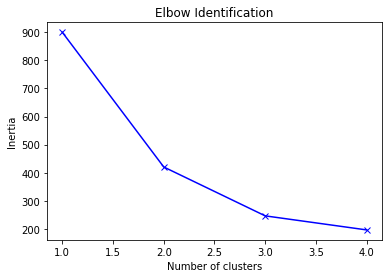

In [13]:
inertia=[]
K=range(1,5)
for k in K:
    km=KMeans(n_clusters=k)
    inertia.append(km.fit(X_km).inertia_)

plt.plot(K, inertia, 'bx-')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.title('Elbow Identification')
plt.show();

### 5.2 Hierarchical Clustering

Unlike KMeans which needs to be told about the number of clusters to make, hierarchical clustering doesn't need that. It produces a tree like representation of the data that informs the number of clusters and the observations falling in those clusters. This tree like structure is called a dendrogram. Here, we will discuss agglomerative clustering which is indicated by an upside down tree. As we move up this tree, leaves start to fuse/merge together into braches indicating that these are similar observations. As we move higher up, braches or banches and leaves start merging. The sooner these leaves/branches merge, more similar these observations are. Those observations that merge later, are quite different from each other. The height at which these observations merge indicate how different these observations are. When we are at the bottom of the upside down tree, it is easier to determine if 2 observations are similar enough to merge but as we climb up, we now have to merge clusters.

Here creation of dendrogram is just to view the data and not to decide the number of clusters; we already know data needs to be divided into 3 clusters. We can use the dendrogram to decide on the linkage method that best suits our dataset.

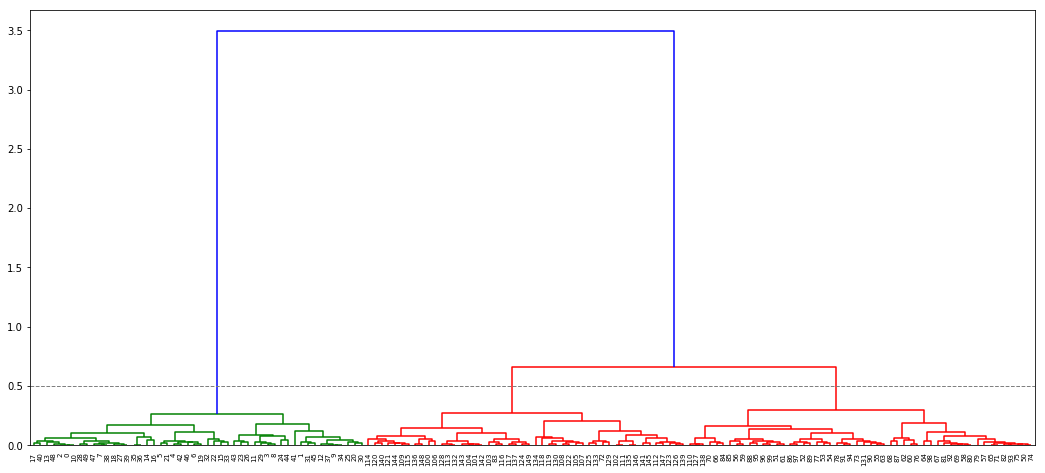

In [36]:
from sklearn.preprocessing import normalize
X_hc=pd.DataFrame(normalize(X[['sepal_width', 'sepal_length', 'petal_width', 'petal_length']]),
                  columns=['sepal_width', 'sepal_length', 'petal_width', 'petal_length'])

from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
fig,ax=plt.subplots(figsize=(18,8))
mergings=linkage(X_hc, method='ward')
dendrogram(mergings, leaf_rotation=90, leaf_font_size=7)
plt.axhline(y=0.5, c='grey', lw=1, linestyle='dashed')
plt.show()

In [37]:
# Implementing Hierarchical clustering using scikit-learn
from sklearn.cluster import AgglomerativeClustering
cluster=AgglomerativeClustering(n_clusters=3, affinity='euclidean', linkage='ward')
cluster.fit_predict(X_hc)

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 2, 2, 2, 0,
       2, 2, 2, 2, 2, 2, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2], dtype=int64)

In [38]:
label=cluster.labels_
species=iris_data['species']
df_hc=pd.DataFrame({'label':label,'species':species})
ct=pd.crosstab(df_hc['label'],df_hc['species'])
print(ct)

species  Iris-setosa  Iris-versicolor  Iris-virginica
label                                                
0                  0               48               4
1                 50                0               0
2                  0                2              46


We can see that hierarchical clustering performs much better than K-Means clustering and has very high accuracy as well.

I have created an additional hierarchical model using the two area features as well, accuracy of which is also very good.

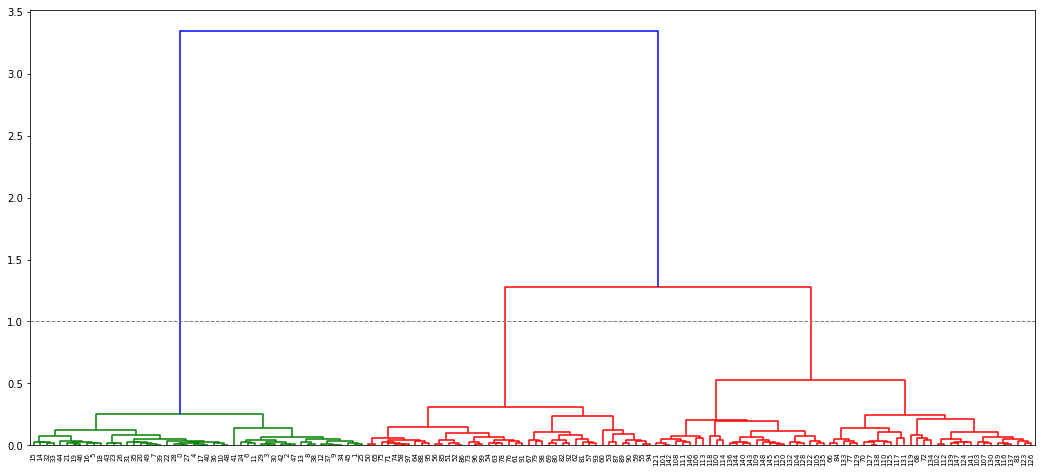

In [39]:
from sklearn.preprocessing import normalize
X_hc_2=pd.DataFrame(normalize(X),columns=X.columns)

from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
fig,ax=plt.subplots(figsize=(18,8))
mergings=linkage(X_hc_2, method='ward')
dendrogram(mergings, leaf_rotation=90, leaf_font_size=7)
plt.axhline(y=1, c='grey', lw=1, linestyle='dashed')
plt.show()

In [40]:
# Implementing Hierarchical clustering using scikit-learn
from sklearn.cluster import AgglomerativeClustering
cluster=AgglomerativeClustering(n_clusters=3, affinity='euclidean', linkage='ward')
cluster.fit_predict(X_hc_2)

label=cluster.labels_
species=iris_data['species']
df_hc=pd.DataFrame({'label':label,'species':species})
ct=pd.crosstab(df_hc['label'],df_hc['species'])
print(ct)

species  Iris-setosa  Iris-versicolor  Iris-virginica
label                                                
0                  0                7              50
1                 50                0               0
2                  0               43               0
